Optimal number of clusters: 4 (Silhouette Score: 0.249)


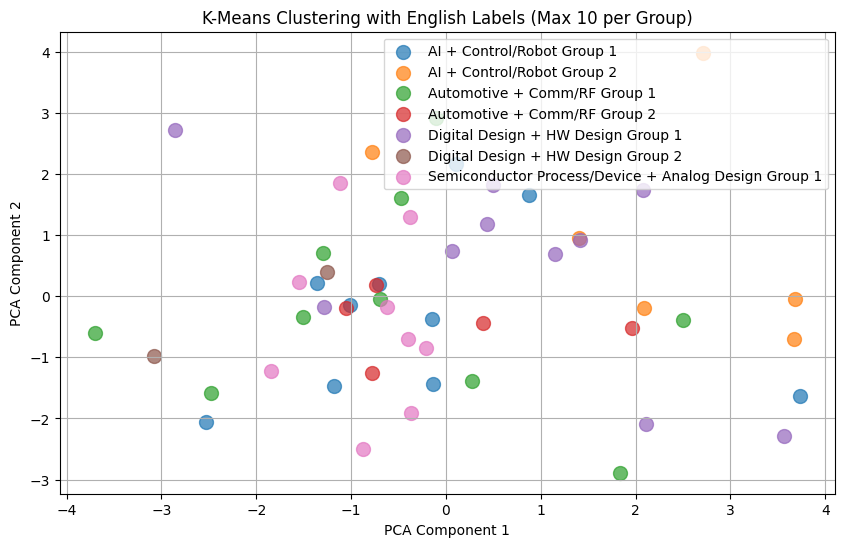

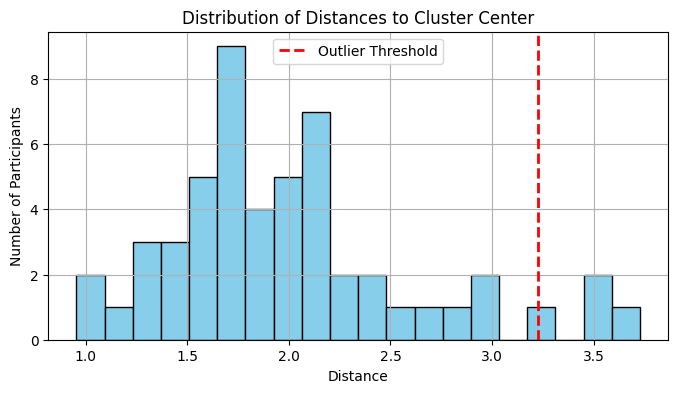

✅ Clustering completed: All labels in English, max 10 per group applied.


In [5]:
# ✅ 1. 라이브러리 설치 및 인증
!pip install --upgrade gspread gspread_dataframe oauth2client

from google.colab import auth
auth.authenticate_user()

import pandas as pd
import gspread
from gspread_dataframe import set_with_dataframe
from google.auth import default
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# ✅ 2. 구글 시트 연결
creds, _ = default()
gc = gspread.authorize(creds)
spreadsheet_url = "https://docs.google.com/spreadsheets/d/1kkt336f1G-XqfDuwCUOnqpKlxTcnwLQy-XS4SQv6lM0/edit"
sh = gc.open_by_url(spreadsheet_url)

# ✅ 3. 시트 불러오기
survey_ws = sh.worksheet("설문지 응답 시트")
score_ws = sh.worksheet("과목별 직무 가중치")

# ✅ 4. 데이터프레임 불러오기
survey_df = pd.DataFrame(survey_ws.get_all_records())
score_df = pd.DataFrame(score_ws.get_all_records())

# ✅ 5. 산업군 한글 → 영어 변환
industry_kor_to_eng = {
    "반도체": "Semiconductor",
    "자동차": "Automotive",
    "AI": "AI",
    "임베디드SW": "Embedded SW",
    "임베디드HW": "Embedded HW",
    "제어/로봇": "Control/Robot",
    "디지털회로설계": "Digital Design",
    "아날로그회로설계": "Analog Design",
    "통신/RF": "Comm/RF",
    "HW설계": "HW Design",
    "SW": "Software",
    "방산": "Defense",
    "반도체 공정/소자": "Semiconductor Process/Device"
}

# ✅ 6. 산업군 이름 영어로 바꾸기
score_df.rename(columns=industry_kor_to_eng, inplace=True)
score_df.set_index("과목명", inplace=True)
industries = list(score_df.columns)

# ✅ 7. 산업군 점수 계산
def calculate_industry_scores(row):
    subjects = [s.strip() for s in row["수강 한 전공 과목 (복수 응답 가능)"].split(",")]
    scores = pd.Series(0, index=industries, dtype=float)
    for subj in subjects:
        if subj in score_df.index:
            scores += score_df.loc[subj]
    total = scores.sum()
    if total > 0:
        scores = scores / total * 100
    return scores

industry_scores_df = survey_df[["이메일 주소", "이름"]].copy()
industry_scores = survey_df.apply(calculate_industry_scores, axis=1)
industry_scores_df = pd.concat([industry_scores_df, industry_scores], axis=1)

# ✅ 8. 정규화 및 최적 k 찾기
X = industry_scores_df[industries].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

best_k = 2
best_score = -1
for k in range(2, min(11, len(X))):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    if score > best_score:
        best_score = score
        best_k = k
print(f"Optimal number of clusters: {best_k} (Silhouette Score: {best_score:.3f})")

# ✅ 9. 클러스터링 수행
kmeans = KMeans(n_clusters=best_k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
distances = kmeans.transform(X_scaled)

industry_scores_df["Cluster"] = clusters
industry_scores_df["Distance_to_Center"] = [distances[i][c] for i, c in enumerate(clusters)]

# ✅ 10. 대표 산업군 2개 추출 (영문 기준)
cluster_centers_df = pd.DataFrame(kmeans.cluster_centers_, columns=industries)
top2_industries = []

for c in clusters:
    top2 = cluster_centers_df.loc[c].sort_values(ascending=False).head(2).index.tolist()
    top2_label = f"{top2[0]} + {top2[1]}"
    top2_industries.append(top2_label)

industry_scores_df["Main_Industries"] = top2_industries

# ✅ 11. 클러스터 내 10명 단위 조 나누기
industry_scores_df = industry_scores_df.sort_values(["Cluster", "Distance_to_Center"]).reset_index(drop=True)
group_assignments = {}
cluster_groupings = defaultdict(list)

for _, row in industry_scores_df.iterrows():
    key = (row["Main_Industries"], row["Cluster"])
    cluster_groupings[key].append(row)

for key, members in cluster_groupings.items():
    industry_label, cluster = key
    for i, start in enumerate(range(0, len(members), 10), 1):
        for m in members[start:start+10]:
            idx = m.name
            group_assignments[idx] = f"{industry_label} Group {i}"

industry_scores_df["Cluster_Name"] = [group_assignments[i] for i in industry_scores_df.index]

# ✅ 12. PCA 시각화
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(10, 6))

for name in sorted(industry_scores_df["Cluster_Name"].unique()):
    idx = industry_scores_df["Cluster_Name"] == name
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=name, s=100, alpha=0.7)

plt.title("K-Means Clustering with English Labels (Max 10 per Group)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()

# ✅ 13. 이상치 탐지
mean_dist = np.mean(industry_scores_df["Distance_to_Center"])
std_dist = np.std(industry_scores_df["Distance_to_Center"])
threshold = mean_dist + 2 * std_dist
industry_scores_df["Outlier"] = industry_scores_df["Distance_to_Center"] > threshold

plt.figure(figsize=(8, 4))
plt.hist(industry_scores_df["Distance_to_Center"], bins=20, color='skyblue', edgecolor='black')
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label='Outlier Threshold')
plt.title("Distribution of Distances to Cluster Center")
plt.xlabel("Distance")
plt.ylabel("Number of Participants")
plt.legend()
plt.grid(True)
plt.show()

# ✅ 14. Google Sheet 업로드
try:
    result_ws = sh.worksheet("Clustered Result with Distance")
    sh.del_worksheet(result_ws)
except:
    pass

result_ws = sh.add_worksheet(title="Clustered Result with Distance", rows=100, cols=20)
set_with_dataframe(result_ws, industry_scores_df)

print("✅ Clustering completed: All labels in English, max 10 per group applied.")
